# Getting Started with the Arize Platform - Investigating Performance Degredation

**In this walkthrough, we are going to investigate a performance drop and get to the bottom of why it happened.** 

You manage the fraud detection model for the widely used [Lending Club](https://www.lendingclub.com/). One day you're alerted to a huge spike in customer complaints - people's loans are wrongly being flagged left and right as fraud! Realizing you have no way of investigating this, you turn to Arize to monitor and observe what changed in your previously working fraud detection model.

Our steps to resolving this issue will be :

1. Get our model onto the Arize platform to investigate
2. Setup a performance dashboard to look at prediction accuracy
3. Understand where the model is underperforming
4. Discover the root cause of why a slice (grouping) of predictions is underperforming (teaser - it's drift!)


# Step 0. Setup and Getting the Data 

We will load in some preexisting data for the Lending Club fraud detection model - training data, test data, and predictions. Using the preexisting model saves time in this example and also illustrates how simple it is to plug into the Arize platform.


###Install Dependencies and Import Libraries 📚

In [1]:
!pip install arize -q
!pip install tables --upgrade -q

import pandas as pd
import requests
import io
from arize.types import ModelTypes
import datetime
import concurrent.futures as cf

print("✅ Dependencies installed and libraries imported!")
print("🕓 Completed at: " + str(datetime.datetime.now()))

     |████████████████████████████████| 286kB 3.7MB/s 
     |████████████████████████████████| 1.3MB 14.2MB/s 
ERROR: tensorflow-metadata 1.0.0 has requirement googleapis-common-protos<2,>=1.52.0, but you'll have googleapis-common-protos 1.51.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
     |████████████████████████████████| 4.3MB 2.3MB/s 
✅ Dependencies installed and libraries imported!
🕓 Completed at: 2021-06-10 16:22:02.691207


### Download the Data 🌐
For our model we have **3 Environments**: training, validation, and production. These environments are essentially three different datasets that correspond to their respective parts of the pre-production - production pipeline. We download each of them, storing them in a dictionary `datasets` for later use. We also download SHAP values.

In [2]:
environments = ['training', 'validation', 'production']
datasets = {}

for environment in environments:
  
  url = 'https://storage.googleapis.com/arize-assets/fixtures/value_showcase_' + environment + '_data.h5'
  r = requests.get(url)
  with open('value_showcase_' + environment + '_data.h5', 'wb') as f:
      f.write(r.content)

  # Create the dataframe and store in dictionary
  datasets[environment] = pd.read_hdf('value_showcase_' + environment + '_data.h5')

# Download the SHAP data to a local file
url = 'https://storage.googleapis.com/arize-assets/fixtures/value_showcase_production_shap.h5'
r = requests.get(url)
with open('value_showcase_production_data_shap.h5', 'wb') as f:
    f.write(r.content)

# Create the SHAP dataframe
lending_data_shap_df = pd.read_hdf("value_showcase_production_data_shap.h5")

features = ['loan_amount',	'term',	'interest_rate',	'installment',	'grade',	'home_ownership',	'annual_income',	'verification_status',	'pymnt_plan',	'purpose',	'addr_state',	'dti',	'delinq_2yrs',	'inq_last_6mths',	'mths_since_last_delinq',	'mths_since_last_record',	'open_acc',	'pub_rec',	'revol_bal',	'revol_util',	'total_acc',	'fico_score',	'fico_range']

print("✅ Data successfully downloaded!")
print("🕓 Completed at: " + str(datetime.datetime.now()))

✅ Data successfully downloaded!
🕓 Completed at: 2021-06-10 16:22:04.477116


# Step 1. Sending Data into Arize 💫

Now that we have our data configured, we are ready to integrate into Arize. We do this by logging (sending) important data we want to analyze to the platform. There, the data will be easily visualized and investigated to source our problem.

For our model, we are going to log:


*   feature data
*   predictions
*   actuals
*   SHAP values for explainability metrics

The first step is to setup our Arize client. After that we will log the data.





## Import and Setup Arize Client

You can find your `API_KEY` and `ORGANIZATION_KEY` on your **[Settings Page](https://app.arize.com/admin)**. Copy those over to the set-up section. We will also be setting up some metadata to use across all logging.

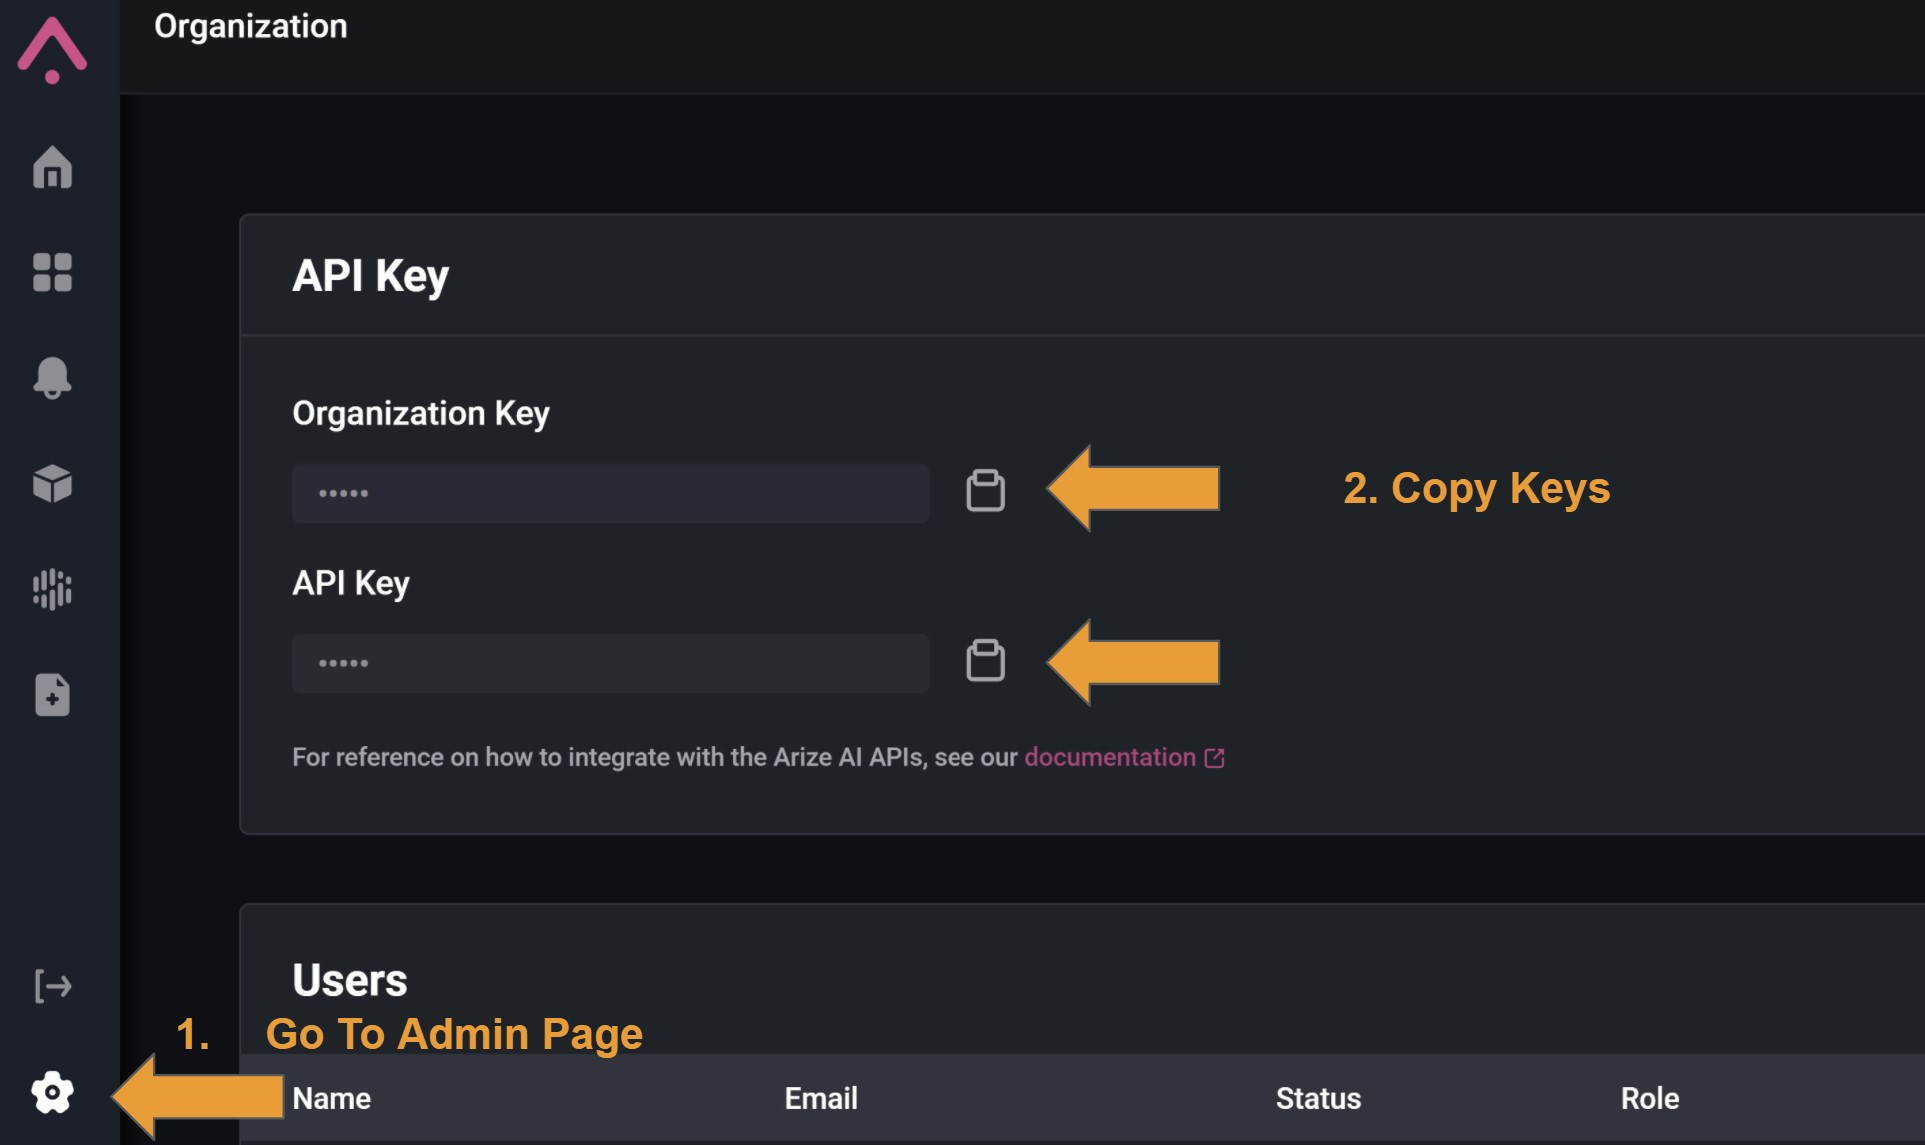

In [3]:
from arize.api import Client
from arize.types import ModelTypes 

ORGANIZATION_KEY = 'ORGANIZATION_KEY'
API_KEY = 'API_KEY'
arize = Client(organization_key=ORGANIZATION_KEY, api_key=API_KEY)

model_id = 'lending-club-performance-degredation-tutorial' # This is the model name that will show up in Arize
model_version = 'v1.0' # Version of model - can be any string

if (ORGANIZATION_KEY == 'ORGANIZATION_KEY' or API_KEY == 'API_KEY'): 
  raise ValueError("❌ NEED TO CHANGE ORGANIZATION AND/OR API_KEY")
else: 
  print("✅ Arize setup complete!")
  print("🕓 Completed at: " + str(datetime.datetime.now()))

✅ Arize setup complete!
🕓 Completed at: 2021-06-10 16:22:04.524924


## Log Data
Now that our Arize client is setup, let's go ahead and log all of our data to the platform.

In [4]:
# Helper listener function
def arize_responses_helper(responses): 
  for response in cf.as_completed(responses):
    res = response.result()
    if res.status_code != 200:
      print(f'future failed with response code {res.status_code}, {res.text}')

# Logging Training Data
training_dataset = datasets['training']
responses = arize.log_training_records(
    model_id=model_id,
    model_version=model_version,
    model_type=ModelTypes.SCORE_CATEGORICAL,
    prediction_labels=training_dataset['predictions'],
    prediction_scores=training_dataset['predictions_score'],
    actual_labels=training_dataset['actuals'],
    features=training_dataset[features],
    )
arize_responses_helper(responses)

# Logging Validation Data
validation_dataset = datasets['validation']
responses = arize.log_validation_records(
    batch_id = str(1),
    model_id=model_id,
    model_version=model_version,
    model_type=ModelTypes.SCORE_CATEGORICAL,
    prediction_labels=validation_dataset['predictions'],
    prediction_scores=validation_dataset['predictions_score'],
    actual_labels=validation_dataset['actuals'],
    features=validation_dataset[features],
    )
arize_responses_helper(responses)

# Logging Production Data
production_dataset = datasets['production']
time_offset = (datetime.datetime.now() - production_dataset['model_date'].max())
log_bulk_responses = arize.bulk_log(
    model_id=model_id,
    model_version=model_version,
    model_type=ModelTypes.SCORE_CATEGORICAL,
    prediction_ids=production_dataset['prediction_ids'],
    prediction_labels=pd.DataFrame({'prediction_labels': production_dataset['predictions'], 'prediction_scores': production_dataset['predictions_score']}),
    actual_labels=production_dataset['actuals'],
    prediction_timestamps=production_dataset['model_date'].apply(lambda t: int((t + time_offset).timestamp())),
    shap_values=lending_data_shap_df,
    features=production_dataset[features]
)
arize_responses_helper(responses)
print("✅ Data successfully logged to Arize!")
print("🕓 Completed at: " + str(datetime.datetime.now()))

✅ Data successfully logged to Arize!
🕓 Completed at: 2021-06-10 16:23:06.240097


# Coffee Time! ☕️
Note that the Arize performs takes about 10 minutes to index the data. While the model should appear immediately, the data will not show up till the indexing is done. Feel free to go grab a cup of coffee as Arize works its magic! 🔮

**⚠️ DON'T SKIP:** 
In order to move on to the next step, make sure your actuals and training/validation sets are loaded into the platform. To check:
1. On the **Overview Tab** make sure you see the actuals as shown below.

2. On the **Datasets** tab and make sure you see in the *Environment* column one for *Training* and *Validation* as shown below.

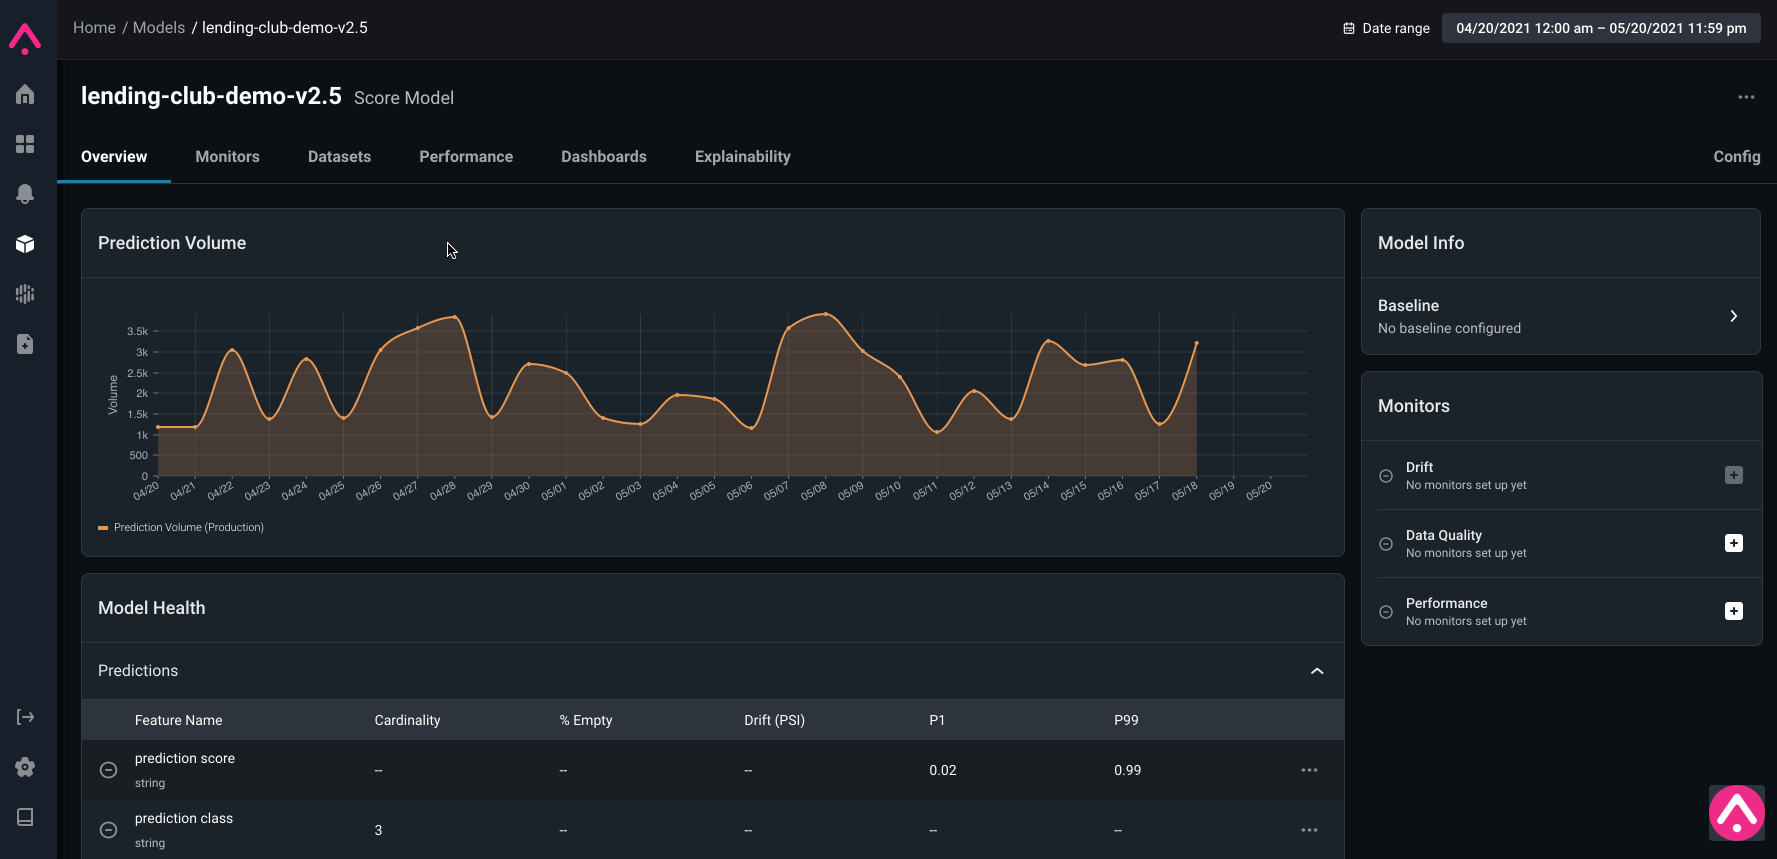

# Step 2. Monitor Performance of Model 


Welcome back! Now we can go take a look at the Arize platform and figure out how our model is performing. Head over to the Models page and select our newly created model `lending-club-tutorial`. The **Overview Tab** should look like this



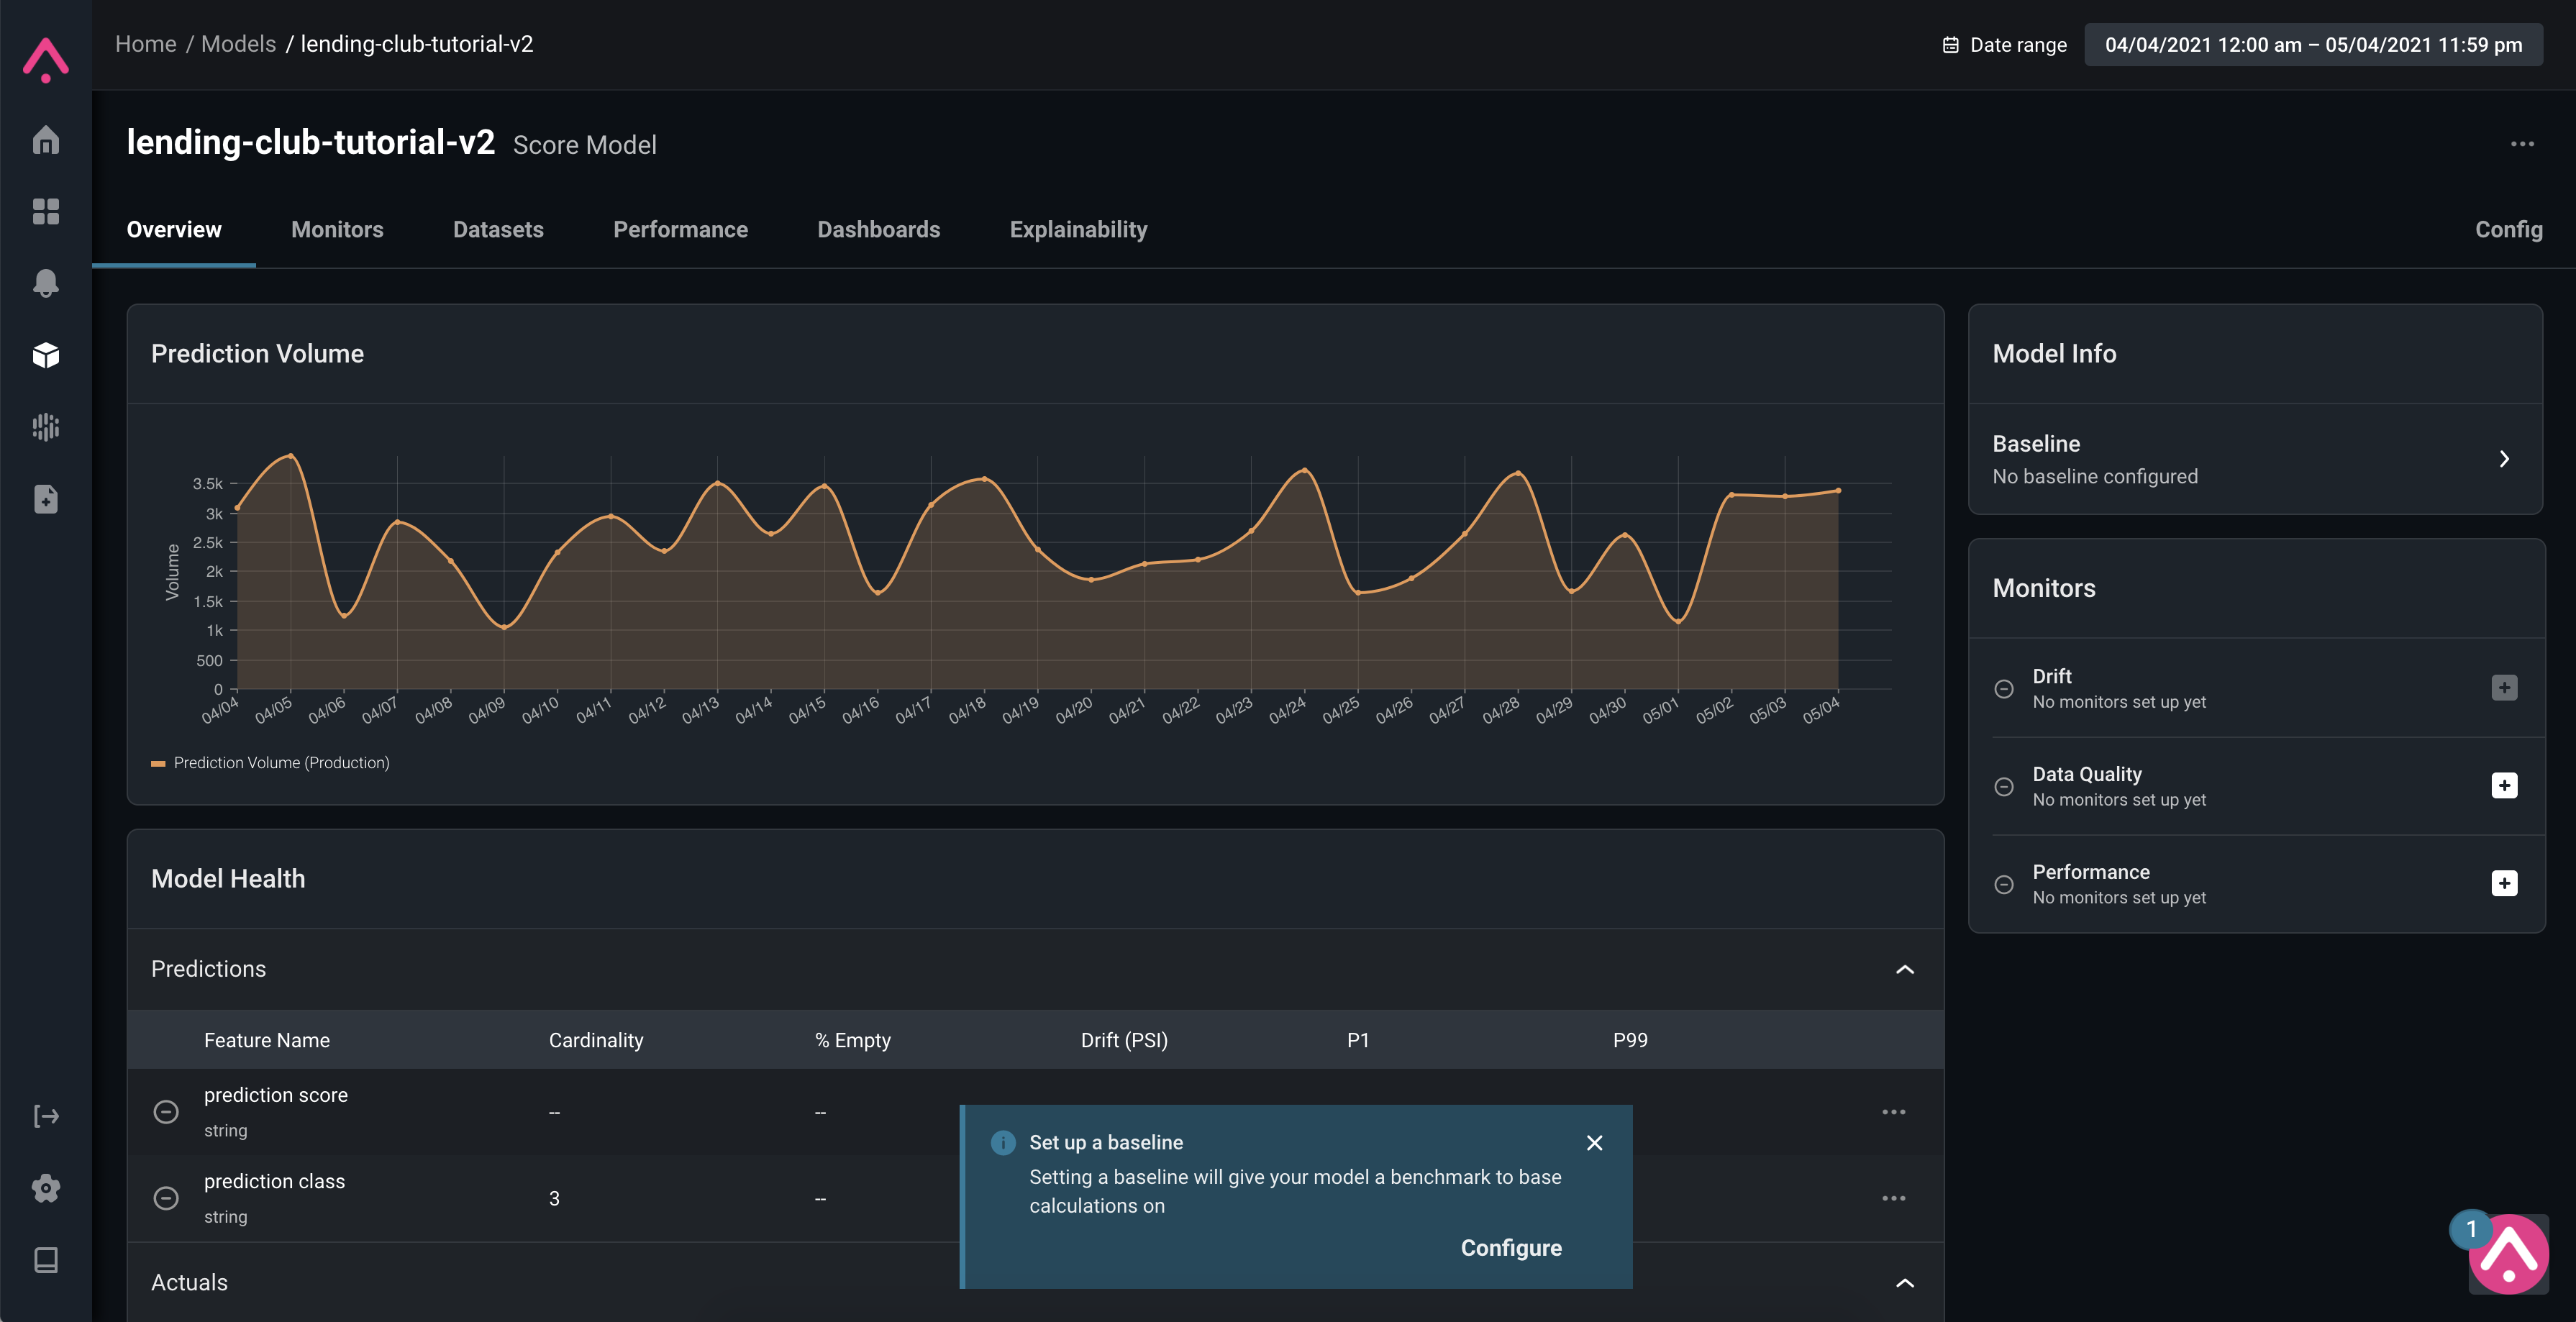

Let's set up a performance monitor to see how our model is doing. This will allow us to track performance metrics and get alerted when the model is underperforming. Head over to the Performance tab on the right and hit the **+** to create a Performance Monitor.

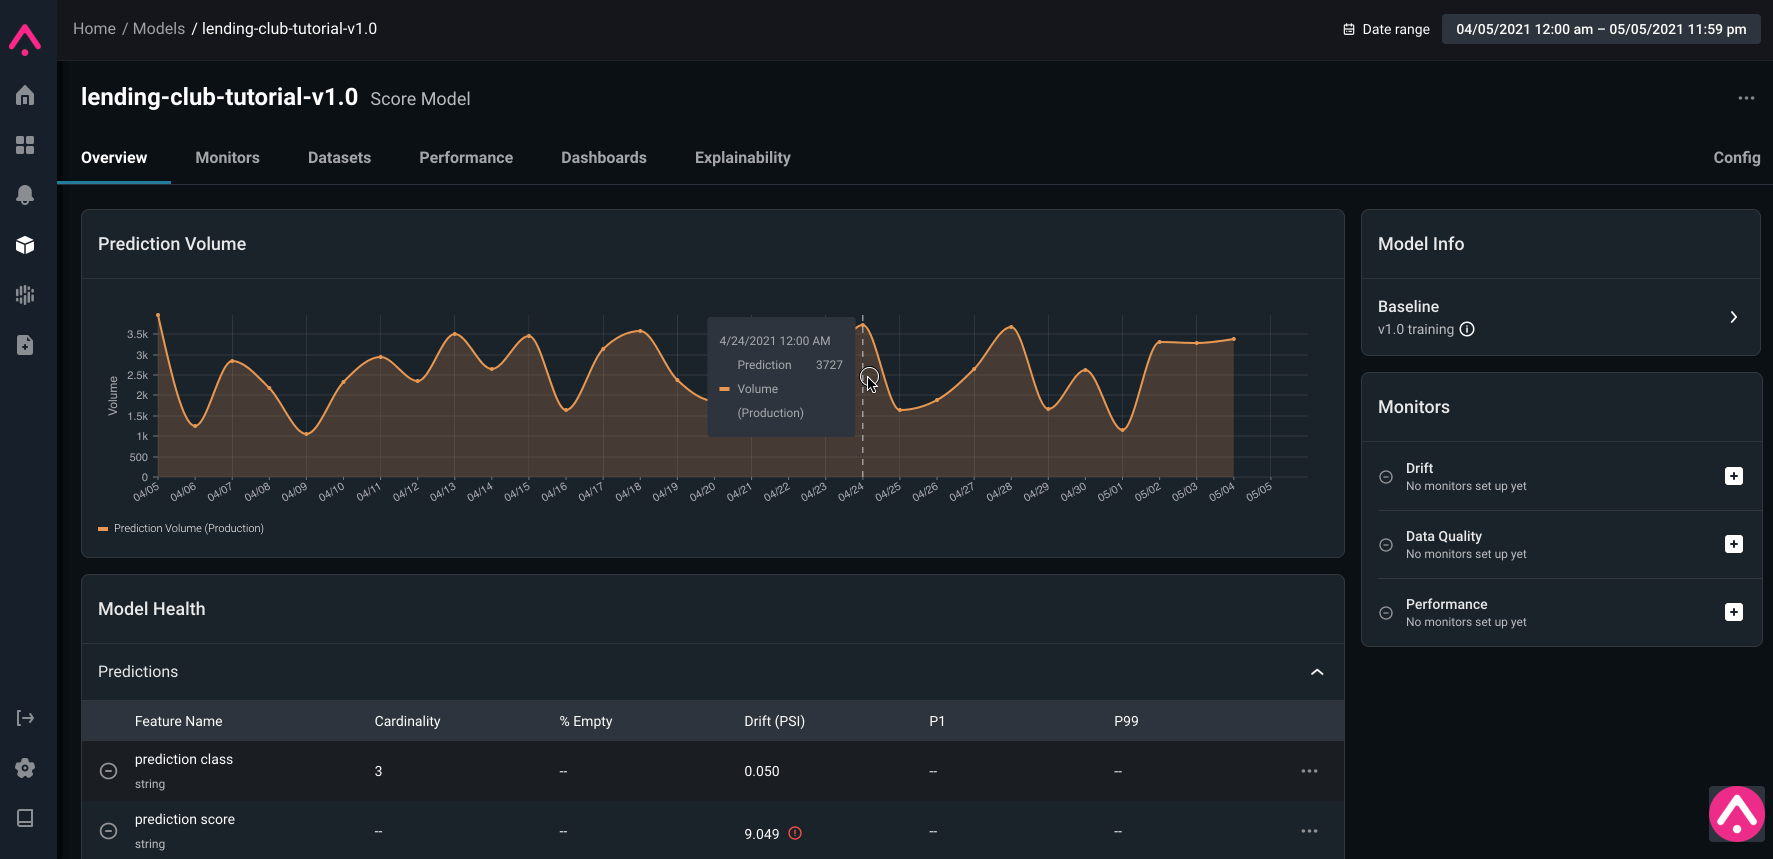

Arize offers a variety of metrics to monitor, and in this example we will be tracking the accuracy. When the accuracy dips below 0.65, the monitor will trigger and you will know to investigate the performance issue. Additionally, you can enter an email address under *Send Trigger Notification to* to alert someone by email when the monitor fires.

Fill out the performance monitor according the following:

| Field      | Value |
| ----------- | ----------- |
| Monitor Name   | Performance Monitor        |
| Model      | *choose your model      |
| Model Versions     | *choose your model version     |
| Evaluation Metric   | Accuracy        |
| Evaluation Window   | 24 hours        |
| Trigger Alert When   | metric is below / 0.65        |


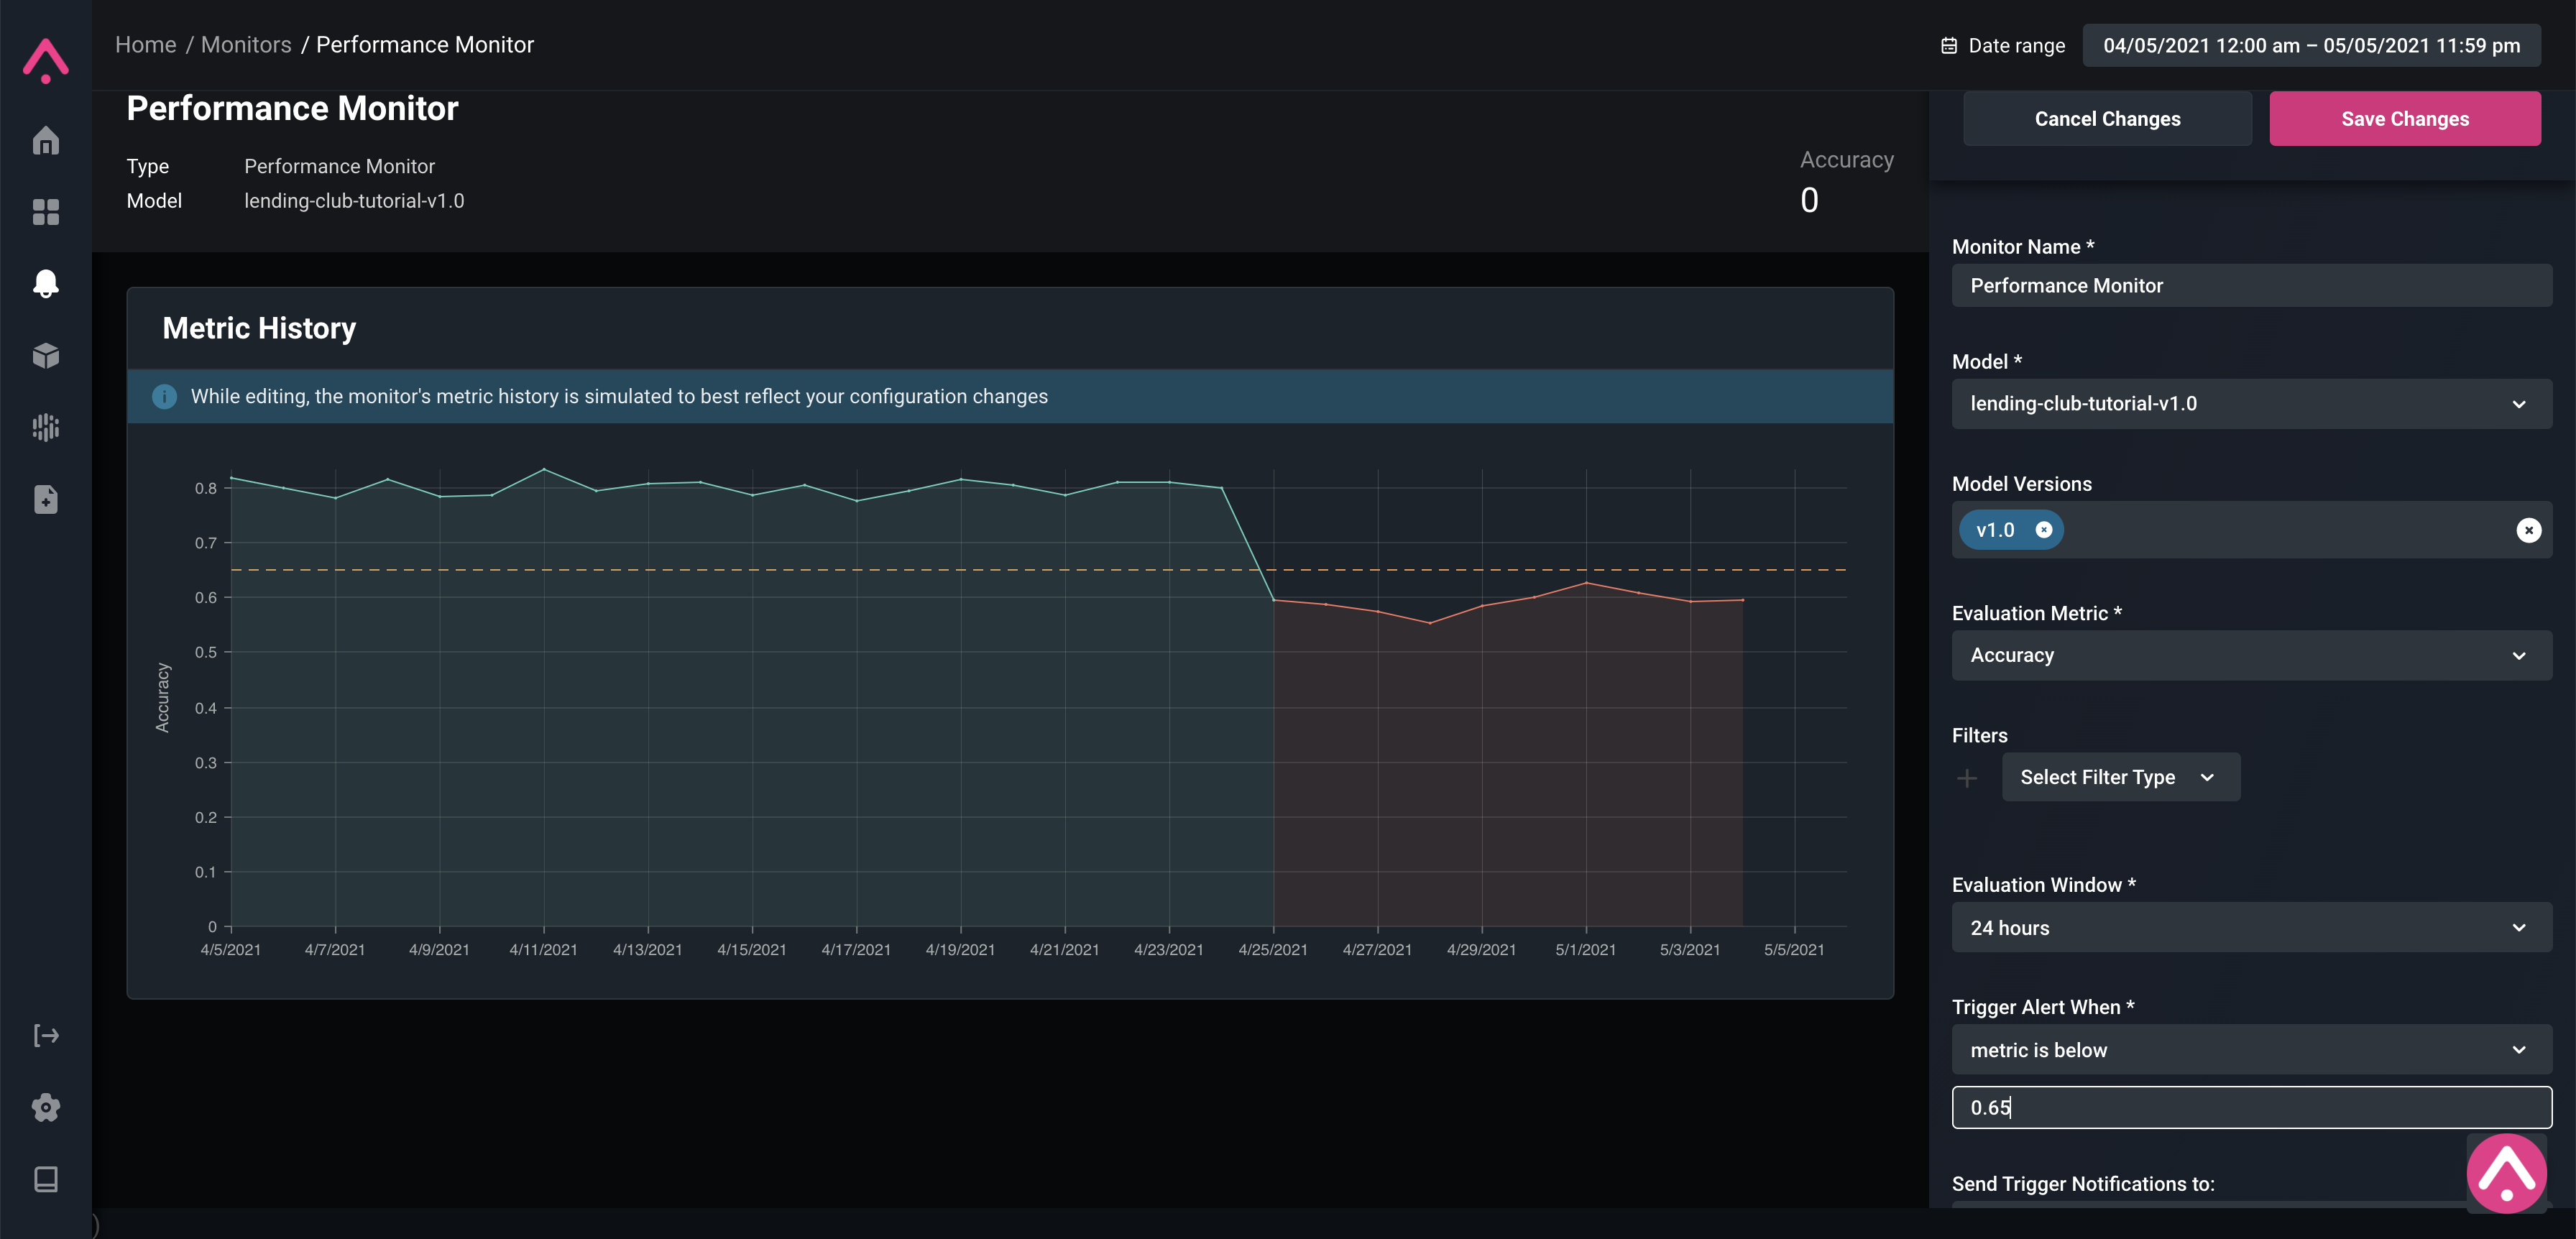

# Step 3. Analyze where Performance is Low
Now that we've identified there is indeed performance degredation, let's do a deeper dive into where it's happening. Arize is great at slicing and dicing data by feature in order to pinpoint where metrics are dipping. One tool to do that is the Feature Performance Heatmap. 

The heatmap tells you what the accuracy is for different slices - which are groupings of predictions based on one or more features. This is illustrated through color, where **Red indicates an underperforming slice, and yellow indicates a good performing slice.** Let's try it out!

Steps: 
1. Head over to the **Dashboards** page and hit **Create Dashboard**. 
2. Create a Feature Performance Heatmap Dashboard

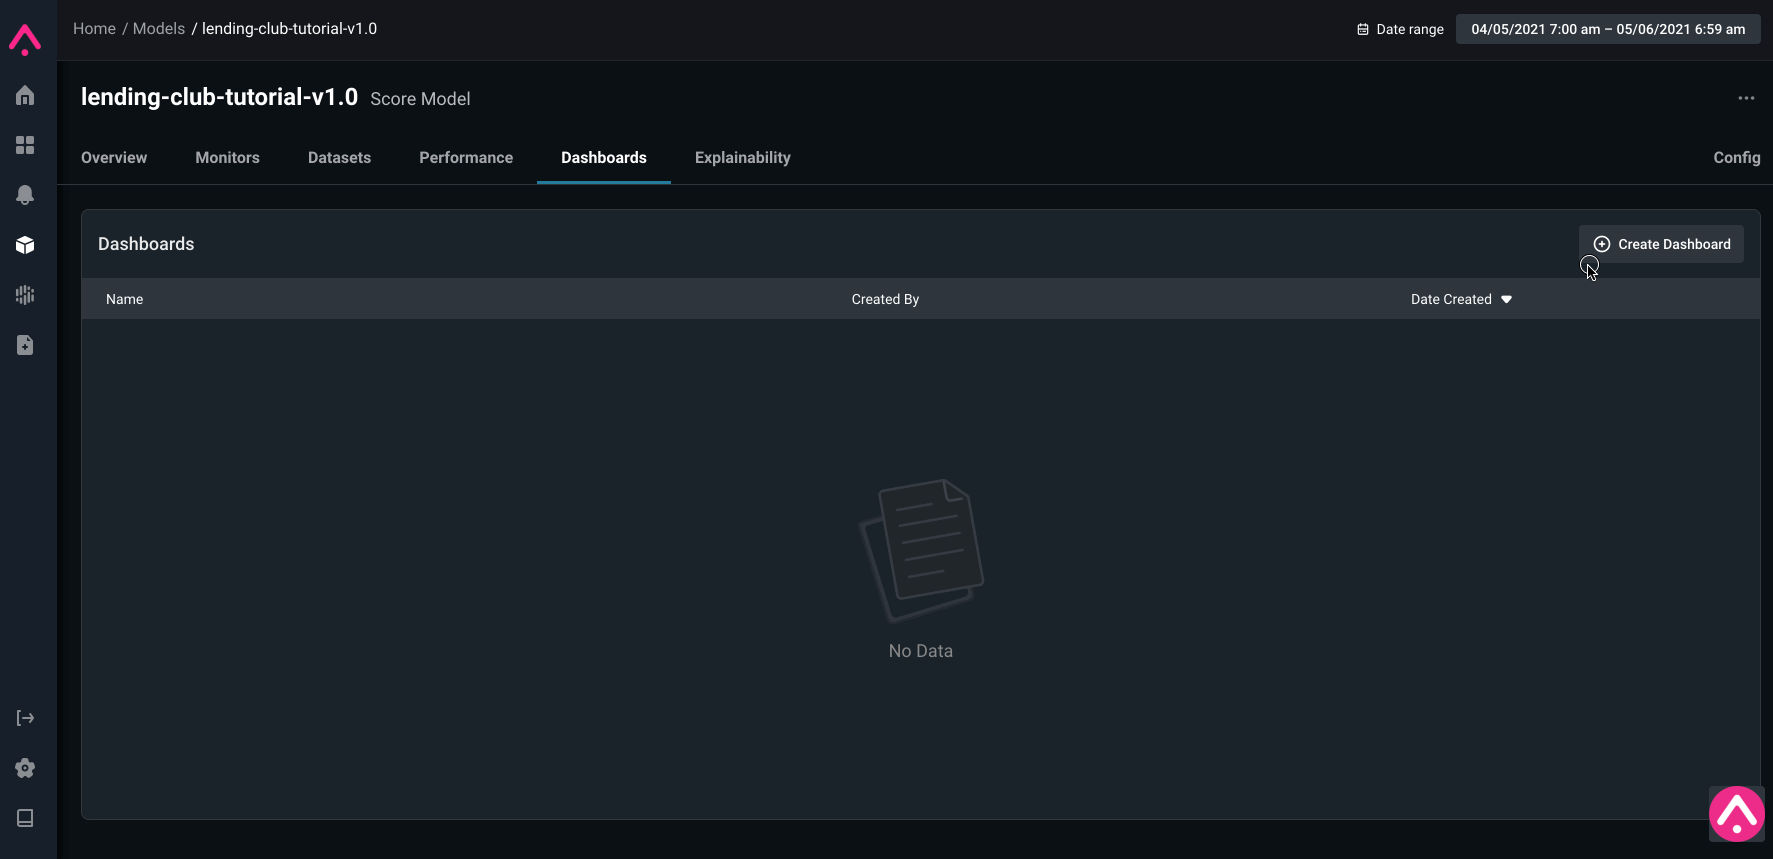

3. Fill out the heatmap fields as follows: 

| Field      | Value |
| ----------- | ----------- |
| Dashboard Name   | Feature Performance Heatmap        |
| Model      | *choose your model      |
| Features   | *select all        |
| Metric   | Accuracy        |

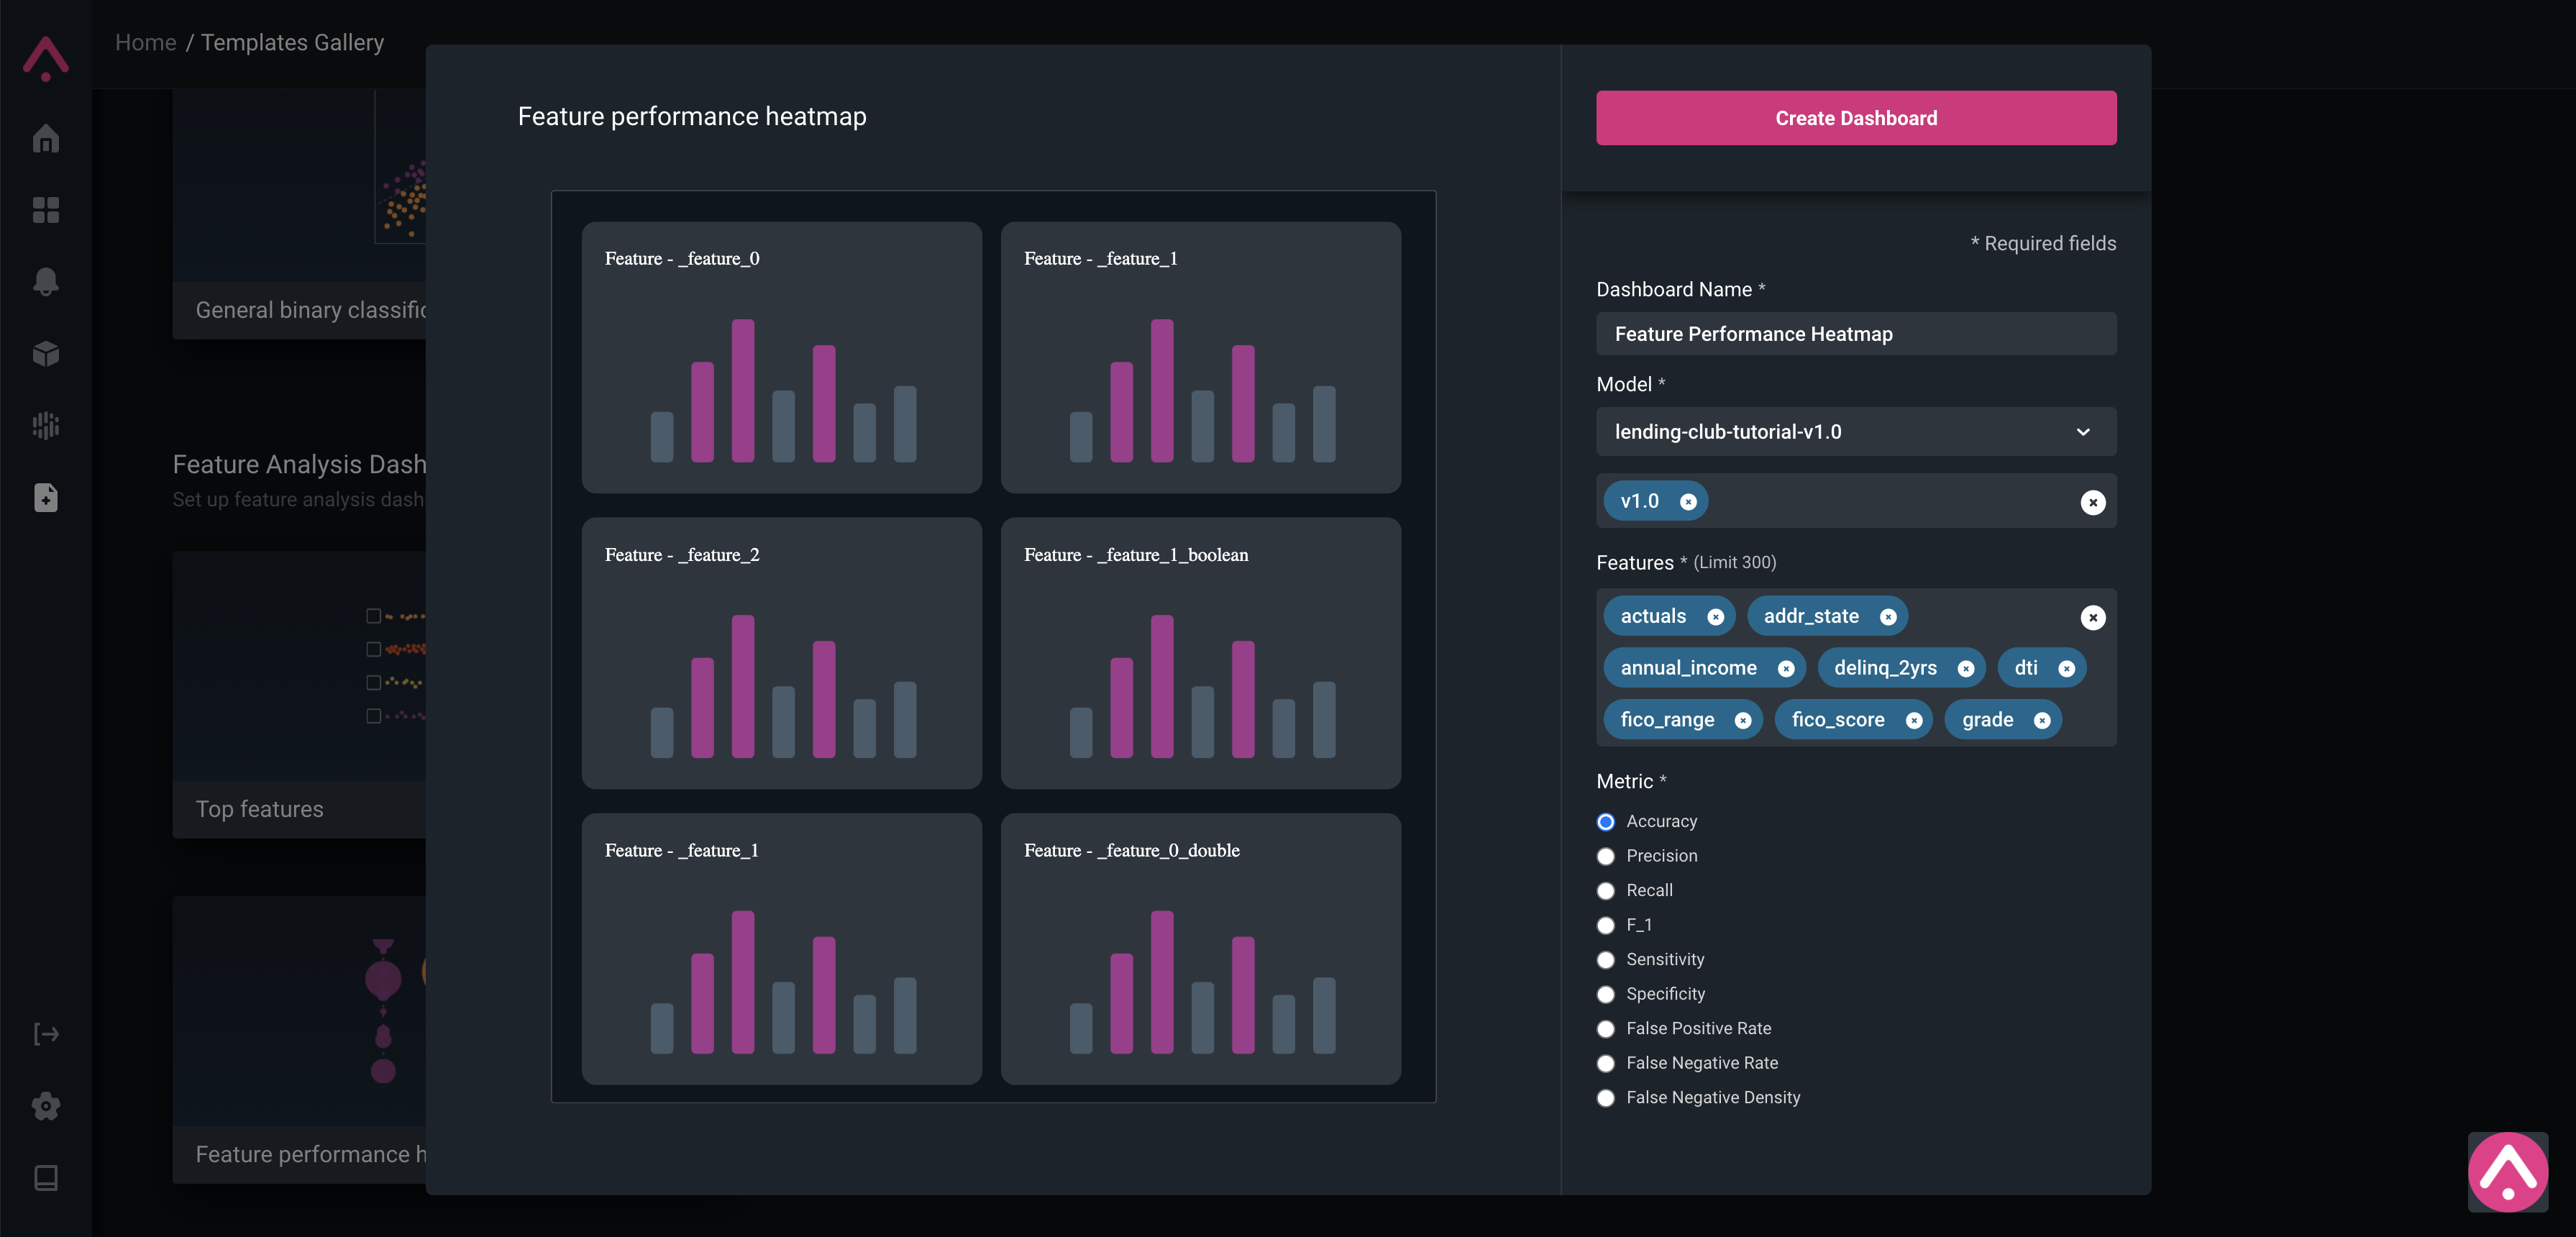

4. Select the *Show Performance Slices* button in the top right corner. You can easily find the worst performing slices ranked worst to best. 

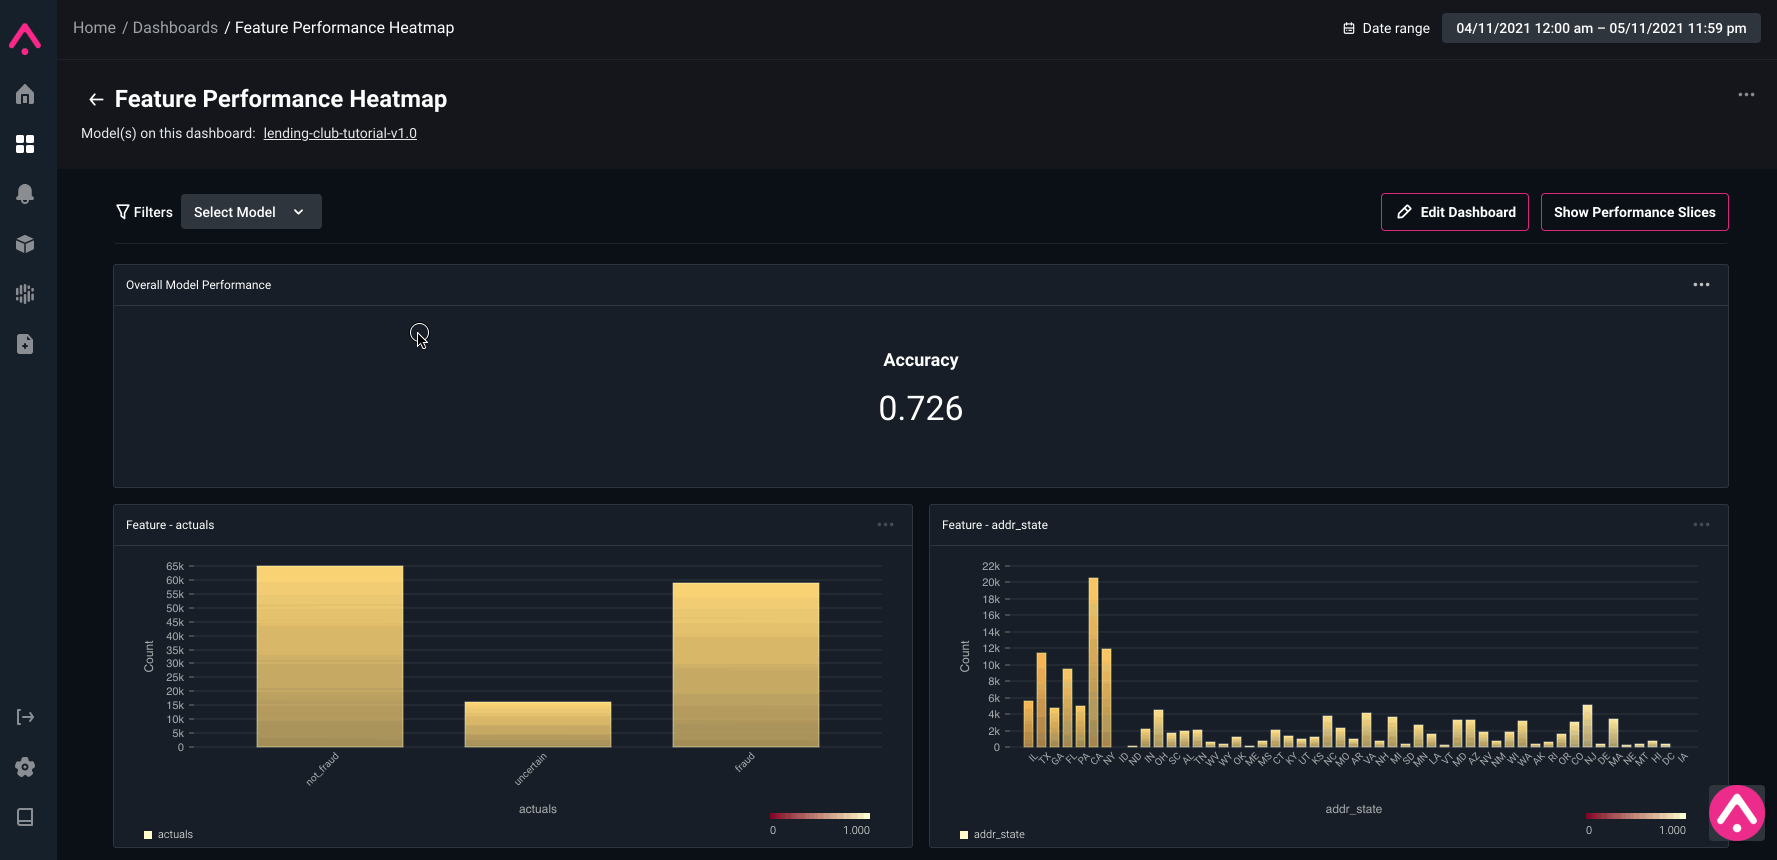

5. Scroll down to the worst performing slice.  We can see where the *purpose* is `pawn_shop_loan` performs the worst. A quick glance at it reveals a huge disparity between the accuracy for `pawn_shop_loan` and `debt_consolidation`. 

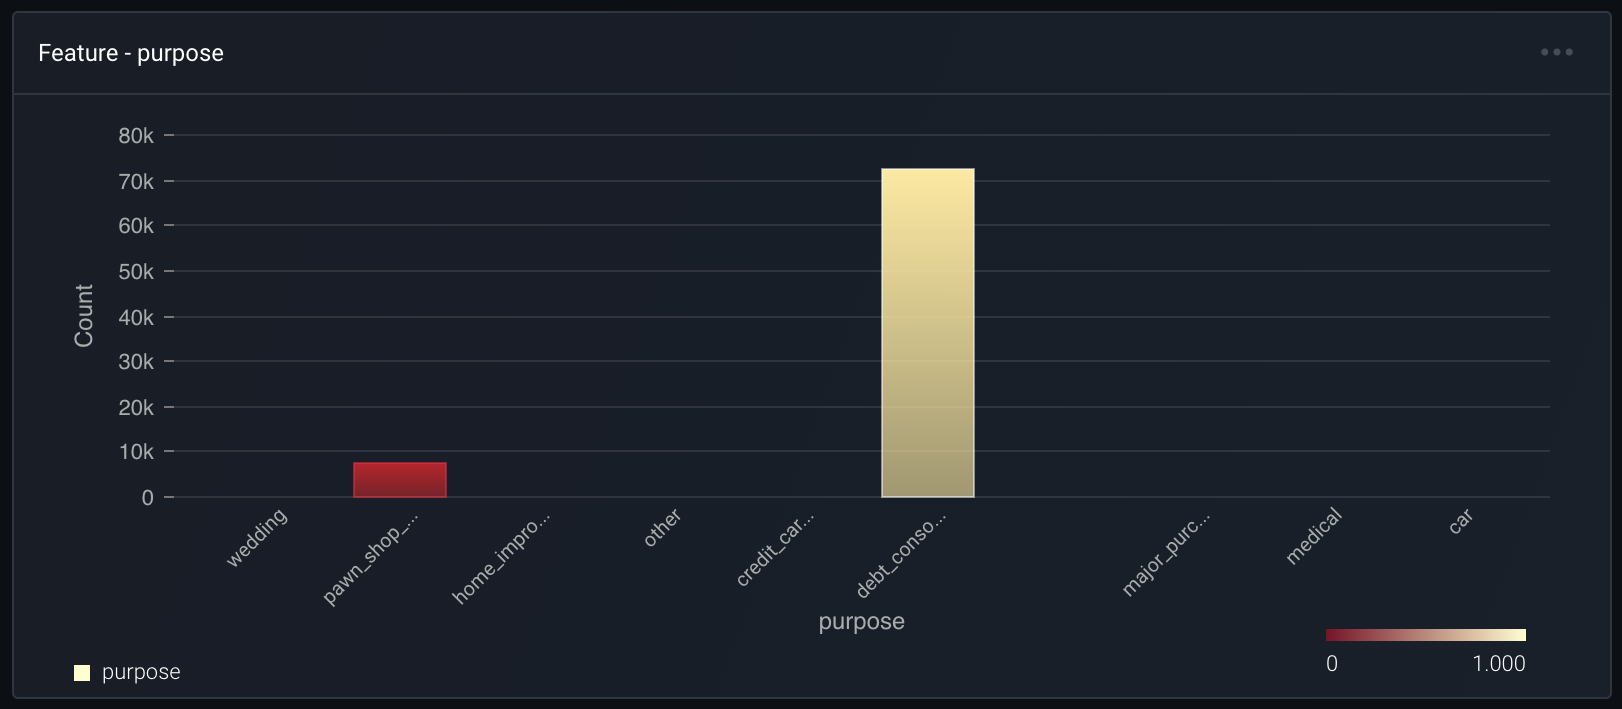


**Congratulations!** 🎉   We tracked down the source of the performance degredation to the data slice where purpose = `pawn_shop_loan`. With this knowledge, we are very close to figuring out exactly the root cause of why our customers are experiencing loan issues. Only the following questions remain.

*Why is this happening? Has this feature drifted? Is there a data quality issue?* Let's get to the bottom of this.

# Step 4. Check if Feature has Drifted

Now that we have identified a single slice being responsible for the performance degredation, let's begin our investigation of what's driving it. One possible root cause is feature drift, which can cause models to suddenly start giving innacurate predictions.

#### A. Set up a Baseline

Before we can look at drift, we need to set up a baseline to compare our model to. Go ahead and click on the **Configure** button in the bottom popup, or by going to the **Baseline** button on the right side of the screen. We're going to set our training data as our baseline. Click **Set as Baseline** under Actions on the training data row, and hit **Confirm** when the popup appears.

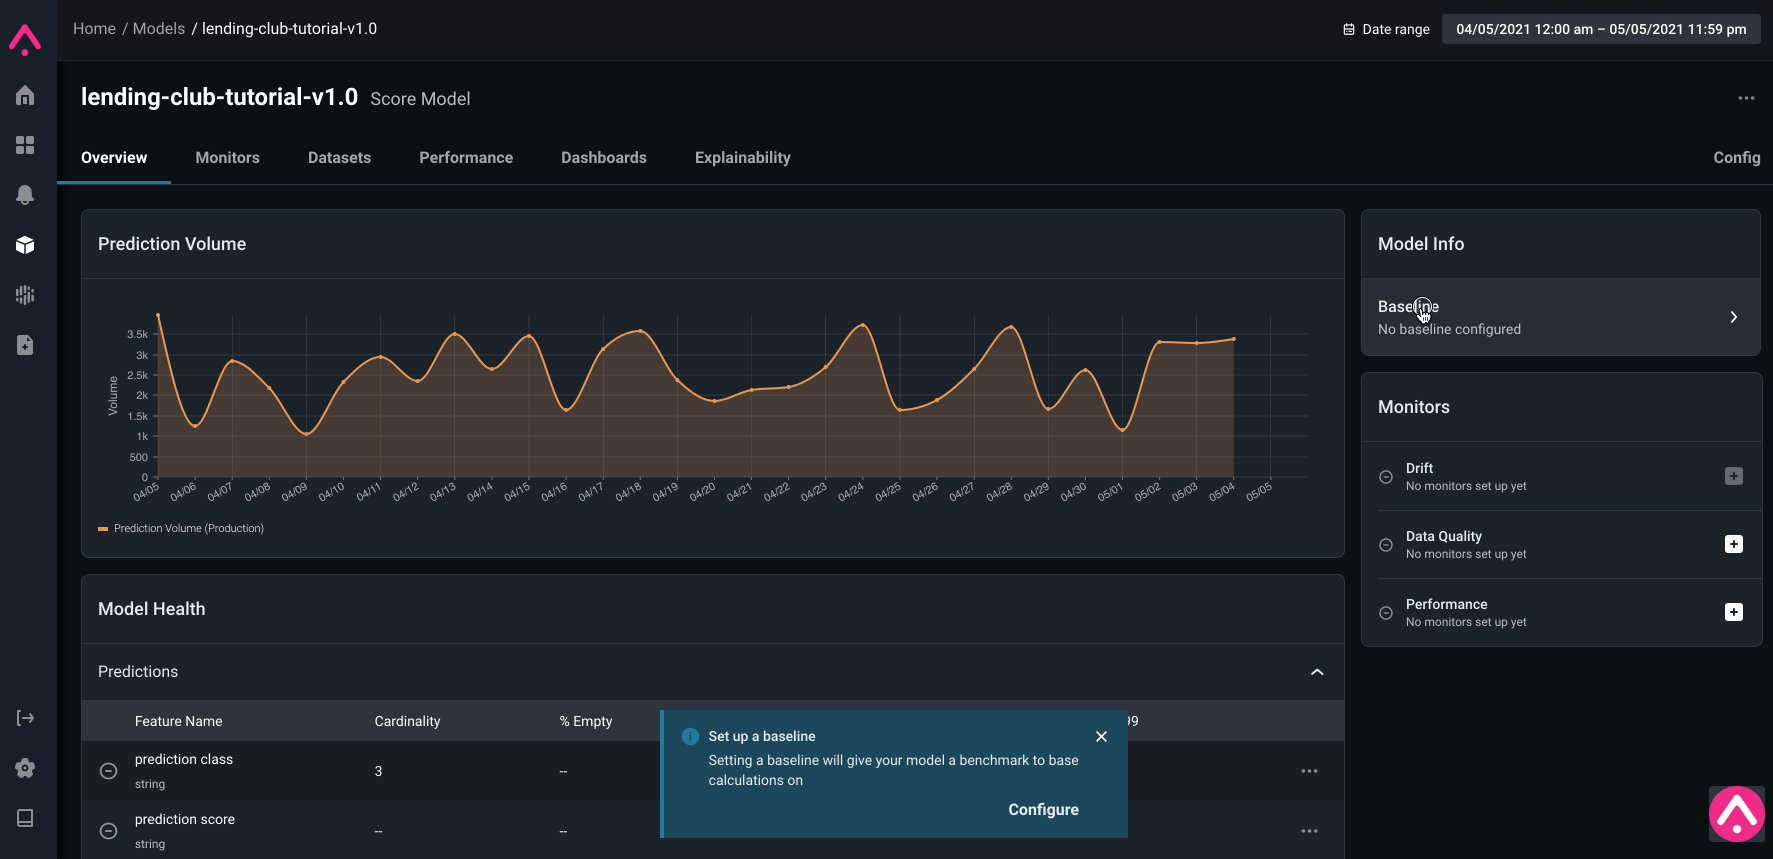



#### B. Creating a Feature Drift Monitor

Head back to the **Model Overview** Tab. Arize allows easy creation of drift monitors for all features using the plus button next to **Drift** on the right side of the screen. Go ahead and press that to set up the drift monitors, which will include the one we are after, the *purpose* feature drift monitor.

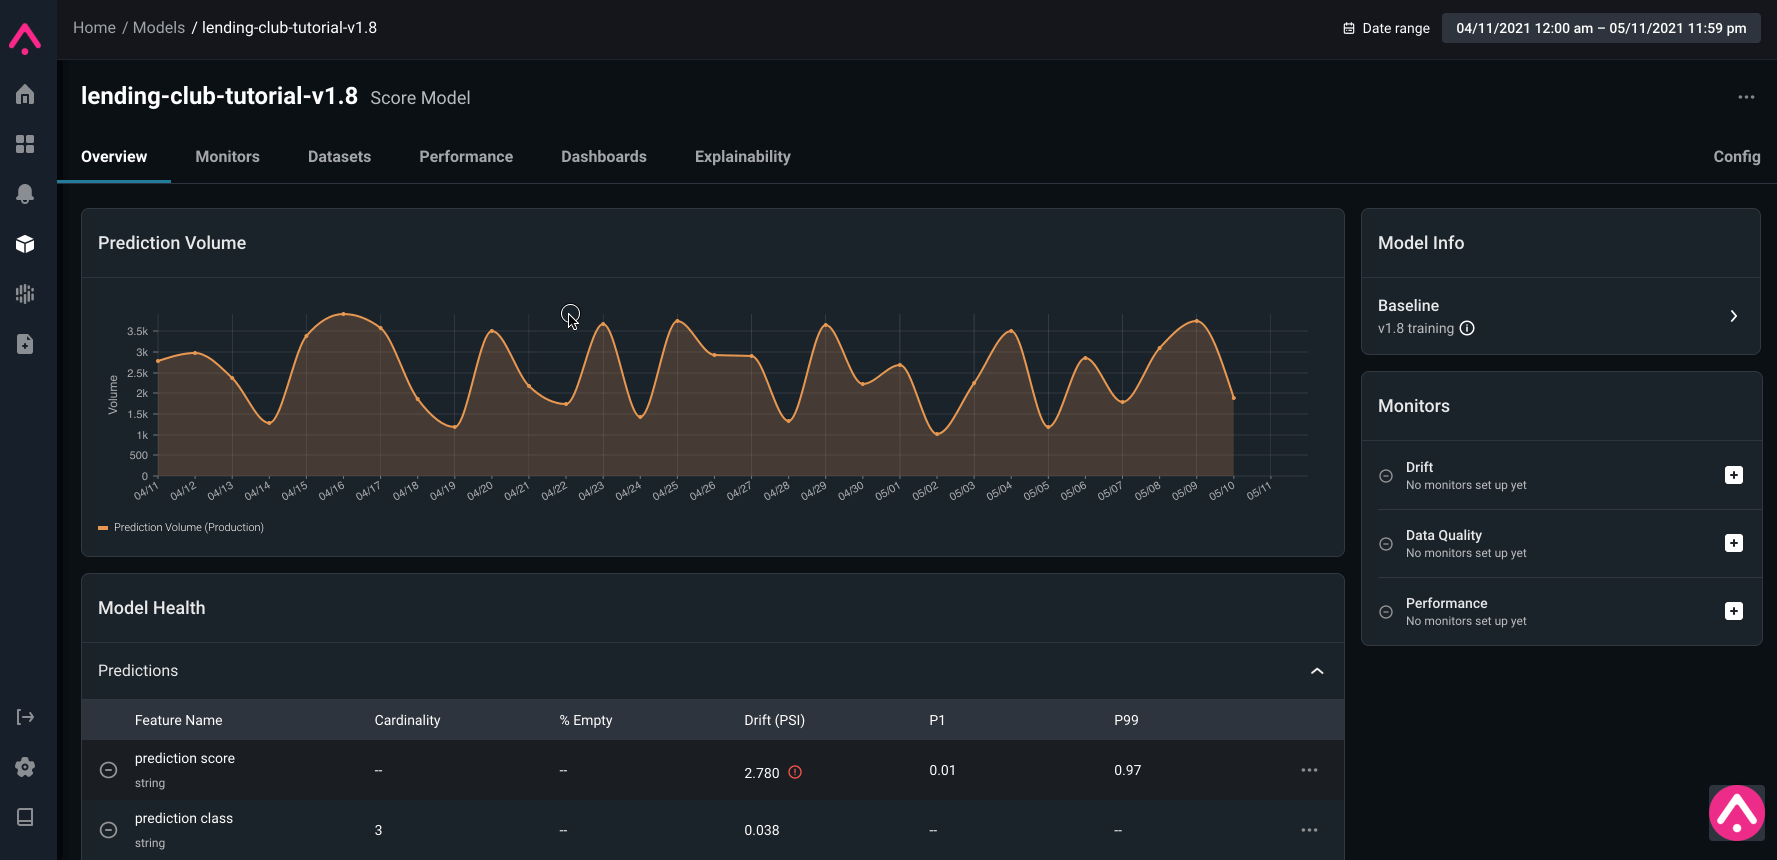

Now that the monitor is setup, let's go and check it out. Clicking on it takes you to a visualization of the feature timeseries, as well as a place to edit the monitor. We demonstrate how email alerts can be setup for when the monitor is triggered.

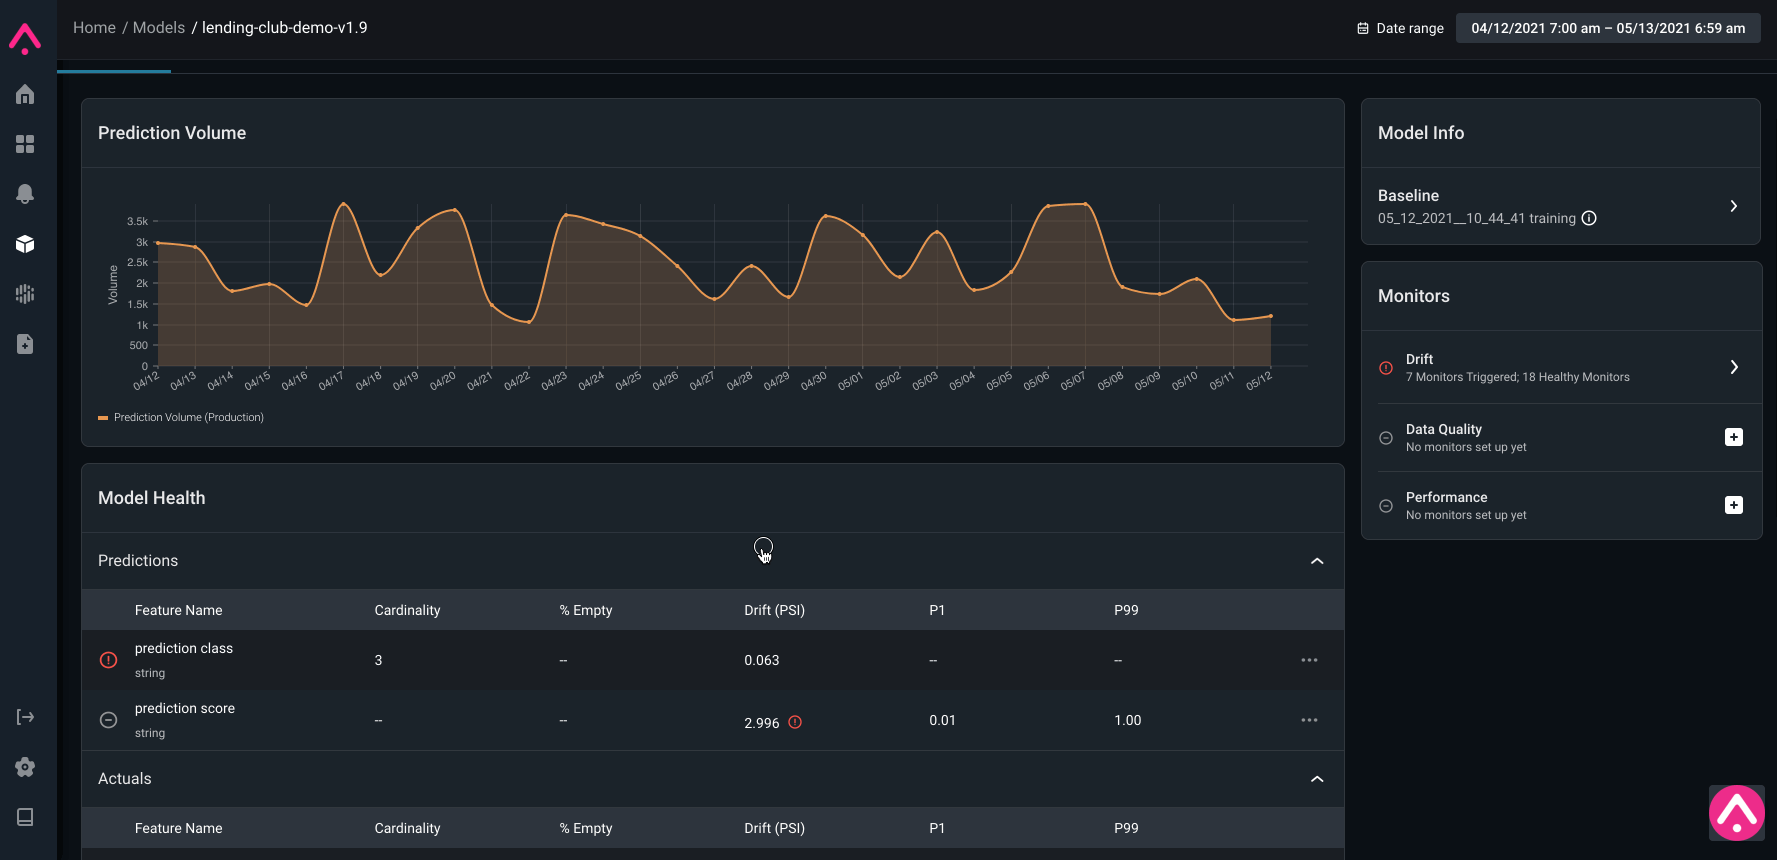

From this monitor, you can clearly see that the purpose feature has drifted a lot, explaining why the slice purpose = `pawn_shop_loan` has been performing so poorly. With this, we finally have actionable information. Addressing the spike in loans made out to pawn shops is where our solution lies. Looking forward, with the monitor set up to notify us of future drift, we can stay on top of our model's performance in the future.

# Wrap Up 🎁

In this walkthrough we've shown how Arize can be used to log prediction data for a model, pinpoint model performance degredation, and set up monitors to catch future issues. Though we covered a lot of ground, this is just scratching the surface of what the Arize platform can do. We urge you to explore more of Arize, either on your own or through one of our many other tutorials.

## Workspace

Visit the [Arize Blog](https://arize.com/blog) and [Resource Center](https://arize.com/resource-hub/) for more resources on ML observability and model monitoring.

https://www.arize.com